In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import sklearn
import scipy
import shap
import pandas as pd
#data1.set_index(['DT'],inplace=True)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
data1 = pd.read_excel('Atm_7.xlsx', 'Sheet1')
mask = (data1['DT'] > '2016-12-01') & (data1['DT'] <= '2020-01-31')
data = data1.loc[mask]
data.set_index(['DT'],inplace=True)

count      1100.0
mean     387636.0
std      168266.0
min        2000.0
25%      272025.0
50%      394600.0
75%      497175.0
max      857500.0
Name: TXN, dtype: float64

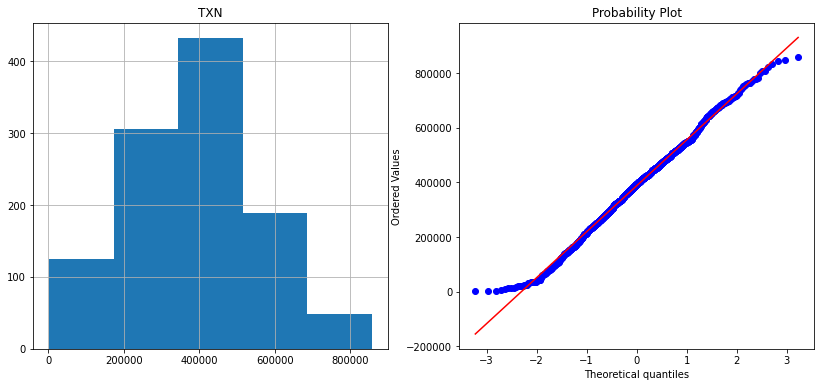

In [71]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['TXN'].hist(bins=5)
plt.title('TXN')
plt.subplot(1,2,2)
scipy.stats.probplot(data['TXN'], plot=plt);
data['TXN'].describe().T.round()

In [46]:
data1['DT'].max()

Timestamp('2021-12-24 00:00:00')

In [50]:
data1[data1['DT'] == data1['DT'].max()]['DAY_WEEK']

1985    FRIDAY   
Name: DAY_WEEK, dtype: object

In [32]:
# Copy the original data
features = data.copy()
# Select the numeric columns
numeric_subset = data[['MONTH','YEAR','MOVING_AVERAGE', 'TXN']]
# Select the categorical columns
# dropped atm_name
categorical_subset = data[['DAY_WEEK','HOLIDAY']]
# One hot encoding
categorical_subset = pd.get_dummies(categorical_subset)
# Join the two dataframes using concat
features = pd.concat([numeric_subset, categorical_subset], axis = 1)
X = features.copy().drop(columns = ['TXN', 'MONTH','YEAR', 'HOLIDAY_W'])
y = features['TXN'].copy()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of Xtrain and Xtest: ', len(Xtrain), len(Xtest))
print('length of ytrain and ytest: ', len(ytrain), len(ytest))

length of Xtrain and Xtest:  880 220
length of ytrain and ytest:  880 220


In [33]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression(positive=True)
linear.fit(Xtrain, ytrain)
# make predictions
lin_pred = linear.predict(Xtest)
linpred = pd.DataFrame(lin_pred[-10:]) # predicting last 10 values
linpred.rename(columns = {0: 'lin_predicted'}, inplace=True) # renaming the column
linpred = linpred.round(decimals=0) # rounding the decimal values
d = pd.DataFrame(data['TXN']).tail(10)
#dt = pd.DataFrame(data['DT']).tail(10)
linpred.index = d.index #= dt.index
# calling last 10 values of original amt wothdrawn
#linpred.index = d.index # mapping the index of both dataframe
linok = pd.concat([linpred, d], axis=1)
linok['accuracy'] = round(linok.apply(lambda row: row.lin_predicted /row.TXN *100, axis = 1),2)
linok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in linok['accuracy']],index = linok.index)
#linok = linok.assign(day_of_week = lambda x: x.index.day_name())
# Prediction vs Actual
print('lin',mean_absolute_percentage_error(d,linpred))

lin 18.701292830092836


In [34]:
def linearreg(data):
    features = data.copy()
    # Select the numeric columns
    numeric_subset = data[['MONTH','YEAR','MOVING_AVERAGE', 'TXN']]
    # Select the categorical columns
    # dropped atm_name
    categorical_subset = data[['DAY_WEEK','HOLIDAY']]
    # One hot encoding
    categorical_subset = pd.get_dummies(categorical_subset)
    # Join the two dataframes using concat
    features = pd.concat([numeric_subset, categorical_subset], axis = 1)
    X = features.copy().drop(columns = ['TXN', 'MONTH','YEAR', 'HOLIDAY_W'])
    y = features['TXN'].copy()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)

    lin_pred = linear.predict(Xtest)
    linpred = pd.DataFrame(lin_pred[-10:]) # predicting last 10 values
    linpred.rename(columns = {0: 'lin_predicted'}, inplace=True) # renaming the column
    linpred = linpred.round(decimals=0) # rounding the decimal values
    d = pd.DataFrame(data['TXN']).tail(10)
    #dt = pd.DataFrame(data['DT']).tail(10)
    linpred.index = d.index #= dt.index
    # calling last 10 values of original amt wothdrawn
    #linpred.index = d.index # mapping the index of both dataframe
    linok = pd.concat([linpred, d], axis=1)
    linok['accuracy'] = round(linok.apply(lambda row: row.lin_predicted /row.TXN *100, axis = 1),2)
    linok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in linok['accuracy']],index = linok.index)
    return linok
    #print('lin',mean_absolute_percentage_error(d,linpred))

In [41]:
import xgboost as xgb
xgb = xgb.XGBRegressor(objective = 'reg:squarederror', learning_rate=0.100000012) 
xgb.fit(Xtrain, ytrain)
xgb_pred = xgb.predict(Xtest) 
xgbpred = pd.DataFrame(xgb_pred[-10:]) 
xgbpred.rename(columns = {0: 'xgbpredicted'}, inplace=True) 
xgbpred = xgbpred.round(decimals=0) 
xgbpred.index = d.index
xgbok = pd.concat([xgbpred, d], axis=1)
xgbok['accuracy'] = round(xgbok.apply(lambda row: row.xgbpredicted / row.TXN*100, axis = 1),2)
xgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in xgbok['accuracy']],index = xgbok.index) 
#xgbok = xgbok.assign(day_of_week = lambda 0: x.index.day_name()) 
print('xgb',mean_absolute_percentage_error(d,xgbpred))
#xgbok 

xgb 16.264647621513404


In [42]:
def xgboost(data):
    features = data.copy()
    # Select the numeric columns
    numeric_subset = data[['MONTH','YEAR','MOVING_AVERAGE', 'TXN']]
    # Select the categorical columns
    # dropped atm_name
    categorical_subset = data[['DAY_WEEK','HOLIDAY']]
    # One hot encoding
    categorical_subset = pd.get_dummies(categorical_subset)
    # Join the two dataframes using concat
    features = pd.concat([numeric_subset, categorical_subset], axis = 1)
    X = features.copy().drop(columns = ['TXN', 'MONTH','YEAR', 'HOLIDAY_W'])
    y = features['TXN'].copy()
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
    xgb_pred = xgb.predict(Xtest) 
    xgbpred = pd.DataFrame(xgb_pred[-10:]) 
    xgbpred.rename(columns = {0: 'xgbpredicted'}, inplace=True) 
    xgbpred = xgbpred.round(decimals=0)
    d = pd.DataFrame(data['TXN']).tail(10)
    xgbpred.index = d.index
    xgbok = pd.concat([xgbpred, d], axis=1)
    xgbok['accuracy'] = round(xgbok.apply(lambda row: row.xgbpredicted / row.TXN*100, axis = 1),2)
    xgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in xgbok['accuracy']],index = xgbok.index) 
    #xgbok = xgbok.assign(day_of_week = lambda 0: x.index.day_name())
    return xgbok
    #print('xgb',mean_absolute_percentage_error(d,xgbpred))

In [43]:
xgboost(dat)

,xgbpredicted,TXN,accuracy
1976,295665.0,1,29566500.00%
1977,271781.0,1,27178100.00%
1978,312935.0,1,31293500.00%
1979,331487.0,1,33148700.00%
1980,168903.0,1,16890300.00%
1981,309012.0,1,30901200.00%
1982,346779.0,1,34677900.00%
1983,331693.0,1,33169300.00%
1984,383250.0,1,38325000.00%
1985,236656.0,1,23665600.00%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


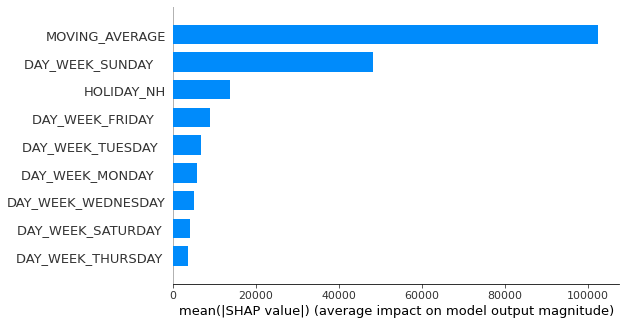

In [94]:
shap_values = shap.TreeExplainer(xgb).shap_values(Xtest)
shap.summary_plot(shap_values, Xtest, plot_type="bar")

In [11]:
X = data[['DAY','MONTH','YEAR','MOVING_AVERAGE', 'DAY_WEEK', 'HOLIDAY']]
y = data['TXN']
#X = data.iloc[:, 2:10].copy()
#y = data.iloc[:, 10].values
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))

length of X_train and X_test:  880 220
length of y_train and y_test:  880 220



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [81]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 880 entries, 2016-12-14 to 2019-06-25
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DAY             880 non-null    int64   
 1   MONTH           880 non-null    int64   
 2   YEAR            880 non-null    int64   
 3   MOVING_AVERAGE  880 non-null    float64 
 4   DAY_WEEK        880 non-null    category
 5   HOLIDAY         880 non-null    category
dtypes: category(2), float64(1), int64(3)
memory usage: 36.6 KB


In [12]:
import lightgbm as lgb
import time
# Similarly LGBMRegressor can also be imported for a regression model.
from lightgbm import LGBMClassifier
gbm = lgb.LGBMRegressor(objective='regression', num_leaves=31, randomstate=42, learning_rate=0.4, n_estimators=100)
gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric ='rmse', early_stopping_rounds = 10, verbose =50) 

lgb_pred = gbm.predict(X_test, num_iteration = gbm.best_iteration_) 
lgbpred = pd.DataFrame(lgb_pred[-10:]) 
lgbpred.rename(columns = {0: 'lgbpredicted'}, inplace=True) 
lgbpred = lgbpred.round(decimals=0) 
d = pd.DataFrame(data['TXN']).tail(10)
#dt = pd.DataFrame(data['DT']).tail(10)
lgbpred.index = d.index
lgbok = pd.concat([lgbpred, d], axis=1) 
lgbok['accuracy'] = round(lgbok.apply(lambda row: row.lgbpredicted / row.TXN*100, axis = 1),2)
lgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in lgbok['accuracy']],index = lgbok.index) 
#lgbok = lgbok.assign(day_of_week = lambda 0: x.index.day_name()) 
lgbok 
print('lgb',mean_absolute_percentage_error(d,lgbpred))

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] Unknown parameter: randomstate
lgb 13.356954475801667


In [14]:
def lgbreg(data):
    X = data[['DAY','MONTH','YEAR','MOVING_AVERAGE', 'DAY_WEEK', 'HOLIDAY']]
    y = data['TXN']
    #X = data.iloc[:, 2:10].copy()
    #y = data.iloc[:, 10].values
    # Transform categorical features into the appropriate type that is expected by LightGBM
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
    lgb_pred = gbm.predict(X_test, num_iteration = gbm.best_iteration_) 
    lgbpred = pd.DataFrame(lgb_pred[-11:]) 
    lgbpred.rename(columns = {0: 'lgbpredicted'}, inplace=True) 
    lgbpred = lgbpred.round(decimals=0) 
    d = pd.DataFrame(data['TXN']).tail(11)
    #dt = pd.DataFrame(data['DT']).tail(10)
    lgbpred.index = d.index
    lgbok = pd.concat([lgbpred, d], axis=1) 
    lgbok['accuracy'] = round(lgbok.apply(lambda row: row.lgbpredicted / row.TXN*100, axis = 1),2)
    lgbok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in lgbok['accuracy']],index = lgbok.index) 
    #lgbok = lgbok.assign(day_of_week = lambda 0: x.index.day_name()) 
    #print('lgb',mean_absolute_percentage_error(d,lgbpred)) 
    return lgbok

In [15]:
X = data[[ 'DAY','MONTH','YEAR','MOVING_AVERAGE', 'DAY_WEEK', 'HOLIDAY']]
y = data['TXN']
#X = data.iloc[:, 2:10].copy()
#y = data.iloc[:, 10].values
# Transform categorical features into the appropriate type that is expected by LightGBM
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)
print('length of X_train and X_test: ', len(X_train), len(X_test))
print('length of y_train and y_test: ', len(y_train), len(y_test))
categorical_features_indices = np.where(X.dtypes != np.float)[0]

length of X_train and X_test:  880 220
length of y_train and y_test:  880 220



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
X.dtypes

DAY                  int64
MONTH                int64
YEAR                 int64
MOVING_AVERAGE     float64
DAY_WEEK          category
HOLIDAY           category
dtype: object

In [16]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(random_seed = 42, iterations=5,
                          learning_rate=0.8,
                          depth=2)
cat.fit(X_train, y_train, cat_features = categorical_features_indices,  eval_set=[(X_test, y_test)], early_stopping_rounds = 10, verbose =50) 

cat_pred = cat.predict(X_test) 
catpred = pd.DataFrame(cat_pred[-10:])
catpred.rename(columns = {0: 'catpredicted'}, inplace=True) 
catpred = catpred.round(decimals=0)
d = pd.DataFrame(data['TXN']).tail(10)
#dt = pd.DataFrame(data['DT']).tail(10)
catpred.index = d.index #=dt.index
catok = pd.concat([catpred, d], axis=1) 
catok['accuracy'] = round(catok.apply(lambda row: row.catpredicted / row.TXN*100, axis = 1),2)
#catok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in catok['accuracy']],index = catok.index) 
#catok = catok.assign(day_of_week = lambda 0: x.index.day_name()) 
#catok
print('Cat',mean_absolute_percentage_error(d,catpred))

0:	learn: 139122.6991153	test: 117131.5810433	best: 117131.5810433 (0)	total: 152ms	remaining: 608ms
4:	learn: 113321.1853524	test: 112113.8612671	best: 112113.8612671 (4)	total: 194ms	remaining: 0us

bestTest = 112113.8613
bestIteration = 4

Cat 17.032421090271257


In [17]:
def catboostreg(data):    
    X = data[[ 'DAY','MONTH','YEAR','MOVING_AVERAGE', 'DAY_WEEK', 'HOLIDAY']]
    y = data['TXN']
    #X = data.iloc[:, 2:10].copy()
    #y = data.iloc[:, 10].values
    # Transform categorical features into the appropriate type that is expected by LightGBM
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle= False, test_size = 0.2, random_state = 42)

    categorical_features_indices = np.where(X.dtypes != np.float)[0]
    cat_pred = cat.predict(X_test) 
    catpred = pd.DataFrame(cat_pred[-10:]) 
    catpred.rename(columns = {0: 'catpredicted'}, inplace=True) 
    catpred = catpred.round(decimals=0) 
    d = pd.DataFrame(data['TXN']).tail(10)
    #dt = pd.DataFrame(data['DT']).tail(10)
    catpred.index = d.index #=dt.index
    catok = pd.concat([catpred, d], axis=1) 
    catok['accuracy'] = round(catok.apply(lambda row: row.catpredicted / row.TXN*100, axis = 1),2)
    #catok['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in catok['accuracy']],index = catok.index) 
    #catok = catok.assign(day_of_week = lambda 0: x.index.day_name()) 
    #print('Cat',mean_absolute_percentage_error(d,catpred))
    return catok

In [36]:
catboostreg(dat)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,catpredicted,TXN,accuracy
1976,265905.0,1,26590500.0
1977,265905.0,1,26590500.0
1978,324453.0,1,32445300.0
1979,324453.0,1,32445300.0
1980,175492.0,1,17549200.0
1981,347536.0,1,34753600.0
1982,324453.0,1,32445300.0
1983,347536.0,1,34753600.0
1984,324453.0,1,32445300.0
1985,265905.0,1,26590500.0


In [35]:
linearreg(dat)

,lin_predicted,TXN,accuracy
1976,252866.0,1,25286600.00%
1977,286931.0,1,28693100.00%
1978,272174.0,1,27217400.00%
1979,311937.0,1,31193700.00%
1980,125389.0,1,12538900.00%
1981,301699.0,1,30169900.00%
1982,332840.0,1,33284000.00%
1983,335464.0,1,33546400.00%
1984,305322.0,1,30532200.00%
1985,251375.0,1,25137500.00%


In [230]:
print('Cat',mean_absolute_percentage_error(d,catpred))
print('lgb',mean_absolute_percentage_error(d,lgbpred))
print('xgb',mean_absolute_percentage_error(d,xgbpred))
print('lin',mean_absolute_percentage_error(d,linpred))

Cat 17.032421090271257
lgb 13.356954475801667
xgb 16.264647621513404
lin 18.701292830092836


In [168]:
print('Cat',mean_absolute_percentage_error(d,catpred))
print('lgb',mean_absolute_percentage_error(d,lgbpred))
print('xgb',mean_absolute_percentage_error(d,xgbpred))
print('lin',mean_absolute_percentage_error(d,linpred))

Cat 17.032421090271257
lgb 13.356954475801667
xgb 16.264647621513404
lin 18.701292830092836


In [169]:
report = pd.concat([d['TXN'],linok['lin_predicted'],catok['catpredicted'],lgbok['lgbpredicted'], xgbok['xgbpredicted']], axis=1)
report

,TXN,lin_predicted,catpredicted,lgbpredicted,xgbpredicted
DT,,,,,
2020-01-22,345600,295243.0,347536.0,331513.0,377196.0
2020-01-23,342400,331142.0,324453.0,340099.0,389769.0
2020-01-24,183500,304699.0,324453.0,283677.0,304616.0
2020-01-25,288000,341046.0,347536.0,304947.0,301344.0
2020-01-26,164600,129797.0,145579.0,173368.0,203169.0
2020-01-27,381000,327858.0,347536.0,343678.0,380376.0
2020-01-28,416600,340654.0,347536.0,357721.0,358240.0
2020-01-29,366000,339985.0,347536.0,398136.0,329175.0
2020-01-30,356300,351916.0,347536.0,395241.0,348639.0


<AxesSubplot:xlabel='DT'>

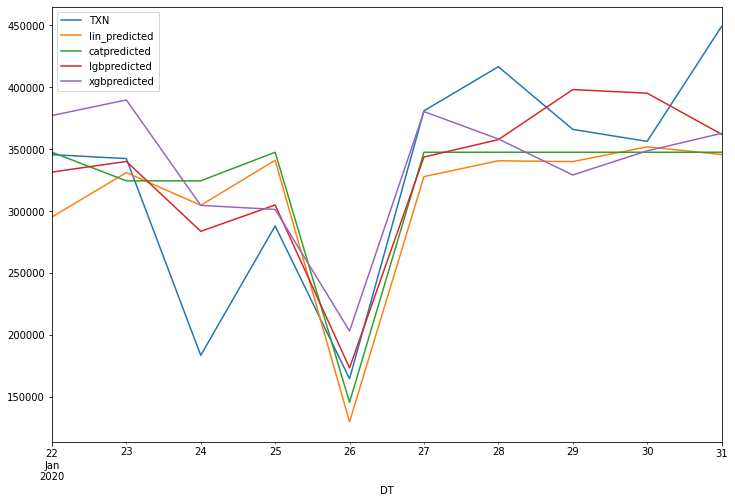

In [170]:
report.plot(figsize=(12,8))

In [24]:
dat = pd.read_excel('Atm_7.xlsx', 'Sheet1')
#dat.set_index(['DT'],inplace=True)
#d = pd.DataFrame(dat['TXN']).tail(10)

In [239]:
#lgbreg(dat)
#xgboost(dat)
#linearreg(dat)
#catboostreg(dat)

Cat 22900110.0


In [47]:
data1 = pd.read_excel('Atm_7.xlsx', 'Sheet1')
mask = (data1['DT'] > '2017-04-01') & (data1['DT'] <= '2020-01-31')
data = data1.loc[mask]
data.set_index(['DT'],inplace=True)
d = pd.DataFrame(dat['TXN']).tail(10)